<a href="https://colab.research.google.com/github/bharathi-srini/Bayesian_Inference_Recommender_Systems/blob/master/basket_context_embeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from keras.models import Model
from keras.layers.core import Dense, Reshape, Lambda
from keras.layers import Input, Embedding, concatenate, Multiply
from keras import backend as K
from keras import optimizers
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras import preprocessing
from keras.regularizers import l2
import random
from keras.layers.advanced_activations import LeakyReLU
import keras
import time

Using TensorFlow backend.


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
# Data of 100 users is used

root_path = 'gdrive/My Drive/BNN_RecSys/'
df_use = pd.read_csv(root_path+"data_100.csv")

In [3]:
# Number of product IDs available
N_products = df_use['product_id'].nunique()
N_shoppers = df_use['user_id'].nunique()

print(N_products,N_shoppers )

6018 100


In [0]:
#Helper to index columns before embeddings
def val2idx(df, cols):
    val_types = dict()
    for c in cols:
        val_types[c] = df[c].unique()

    val_to_idx = dict()
    for k, v in val_types.items():
        val_to_idx[k] = {o: i for i, o in enumerate(val_types[k])}

    for k, v in val_to_idx.items():
        df[k] = df[k].apply(lambda x: v[x]+1)

    unique_vals = dict()
    for c in cols:
        unique_vals[c] = df[c].nunique()

    return df, unique_vals

In [0]:
EMBEDDING_COLUMNS = ["user_id", "product_id"]
df_deep, unique_vals = val2idx(df_use, EMBEDDING_COLUMNS)

In [6]:
# Creating an order size columns for creating purchase sequences later
order_size = pd.DataFrame(df_deep.groupby(['order_id']).size())
order_size = order_size.reset_index()
order_size.columns = {'order_id','size'}

df_deep = df_deep.merge(order_size, how='left', on='order_id')
df_deep.head()

,Unnamed: 0,order_id,product_id,add_to_cart_order,reordered,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_name,aisle_id,department_id,department,size
0,9252892,976653,1,10,1,1,8,2,11,14.000000,Pecan Pie Fruit & Nut Food Bar,3,19,snacks,12
1,31936762,3368597,2,6,1,1,7,2,14,11.000000,Lowfat Key Lime Yogurt,120,16,dairy eggs,12
2,33336496,2226284,3,14,1,1,14,6,13,20.000000,Organic Raspberry Lowfat Yogurt,120,16,dairy eggs,17
3,31936766,3368597,4,10,0,1,7,2,14,11.000000,Gluten Free Pretzel Sticks,107,19,snacks,12
4,10580466,1116941,5,9,0,1,1,6,8,11.364153,Medium Cheddar Cheese Block,21,16,dairy eggs,11


In [0]:
# For every order, we create a row with product ordered and the next product added to basket
orders_list = df_deep.order_id.unique()
first_prod = []
next_prod = []
order_ids = []

for order in orders_list:
  temp = df_deep[df_deep.order_id == order]
  for i in range(int(temp.size) - 1):
    order_ids.append((temp[temp.add_to_cart_order == i].order_id).values)
    first_prod.append((temp[temp.add_to_cart_order == i].product_id).values)
    next_prod.append((temp[temp.add_to_cart_order == i+1].product_id).values)

In [0]:
# Creating dataframe with these sequences
sequence_df = pd.DataFrame(columns={'order_id','first_prod','next_prod'} )
sequence_df.order_id = order_ids
sequence_df.first_prod = first_prod
sequence_df.next_prod = next_prod

for col in sequence_df.columns:
  sequence_df[col] = sequence_df[col].apply(pd.Series)
  
sequence_df = sequence_df.dropna()
sequence_df.to_csv(root_path + 'sequence.csv')

In [0]:
sequence_df = pd.read_csv(root_path + 'sequence.csv')

In [0]:
merged1 = pd.merge(sequence_df, df_deep[['order_id', 'user_id']], how='left', on='order_id')
merged1 = merged1.drop_duplicates()
merged1.head()

In [0]:
basket =df_deep.groupby(['order_id', 'product_id']).size().unstack(fill_value=0)
basket = basket.reset_index()

#Making dataframe sizes equal with a merge
merged = pd.merge(sequence_df, basket, how='left', on='order_id')
merged.shape
merged.to_csv(root_path + 'sequence_final.csv')

In [18]:
print(merged.shape, merged1.shape, sequence_df.shape)
sequence_df.head()

(36572, 6022) (36572, 5) (36572, 4)


,Unnamed: 0,order_id,first_prod,next_prod
0,1,976653.0,2.0,29.0
1,2,976653.0,29.0,17.0
2,3,976653.0,17.0,26.0
3,4,976653.0,26.0,32.0
4,5,976653.0,32.0,19.0


In [22]:
# Input for neural network

product_in = merged['first_prod']
user_in = merged1['user_id']

basket = merged.drop(['Unnamed: 0', 'order_id','first_prod', 'next_prod'], axis=1)

sequence_df['next_prod'] = sequence_df['next_prod'].astype('category', categories = df_deep.product_id.unique())
predicted_product = pd.get_dummies(sequence_df, columns = ['next_prod'])
predicted_product.drop(['Unnamed: 0','order_id','first_prod'], axis=1, inplace=True)

print(product_in.shape, user_in.shape,basket.shape, predicted_product.shape)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead
  import sys


(36572,) (36572,) (36572, 6018) (36572, 6018)


In [24]:
# Test - Train Split
product_tr, product_te, predicted_tr, predicted_te, index_train, index_test = train_test_split(product_in, predicted_product,product_in.index, test_size=0.20,\
                                                                    random_state=42)

user_tr = user_in[index_train]
user_te = user_in[index_test]

basket_tr = basket.loc[index_train]
basket_te = basket.loc[index_test]

print(product_tr.shape, user_tr.shape, predicted_tr.shape, basket_tr.shape)
print(product_te.shape, user_te.shape, predicted_te.shape, basket_te.shape)

/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:696: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]


(29257,) (29257,) (29257, 6018) (29257, 6018)
(7315,) (7315,) (7315, 6018) (7315, 6018)


In [100]:
# Integer IDs representing 1-hot encodings
prior_in = Input(shape=(1,))
shopper_in = Input(shape=(1,))

# Dense N-hot encoding for candidate products
candidates_in = Input(shape=(N_products,))

# Embeddings
prior = Embedding(N_products+1, 10)(prior_in)
shopper = Embedding(N_shoppers+1, 10)(shopper_in)

# Reshape and merge all embeddings together
reshape = Reshape(target_shape=(10,))
combined = keras.layers.concatenate([reshape(prior), reshape(shopper)])

# Hidden layers
hidden_1 = Dense(512, activation='relu')(combined)
hidden_2 = Dense(256, activation='relu')(hidden_1)
hidden_3 = Dense(128, activation='relu')(hidden_2)
hidden_4 = Dense(50, activation='linear')(hidden_3)

# Final 'fan-out' into the space of future products
final = Dense(N_products, activation='linear')(hidden_4)

# Ensure we do not overflow when we exponentiate
final = Lambda(lambda x: x - K.max(x))(final)

# Masked soft-max using Lambda and merge-multiplication
exponentiate = Lambda(lambda x: K.exp(x))(final)
masked = keras.layers.multiply([exponentiate, candidates_in])
predicted = Lambda(lambda x: x / K.sum(x))(masked)

# Compile with categorical crossentropy and adam
mdl = Model(input=[prior_in , shopper_in, candidates_in],
            output=predicted)
mdl.compile(loss='categorical_crossentropy', 
            optimizer=optimizers.Adam(),
            metrics=['accuracy'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("la...)`


In [101]:
start = time.clock()
out = mdl.fit([product_tr , user_tr, basket_tr], predicted_tr ,batch_size=128,
                    epochs=30,
                    verbose=0)
print(time.clock() - start)

522.8662059999988


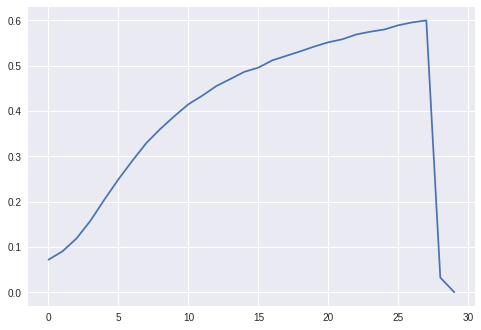

In [102]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(out.history['acc'])
plt.show()

In [103]:
model_json = mdl.to_json()
with open(root_path+"NN_embed_model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
mdl.save_weights(root_path+"NN_embed_model_weights.h5")
print("Saved model to drive")

Saved model to drive


In [104]:
results = mdl.evaluate([product_te , user_te, basket_te], predicted_te)

7315/7315 [==============================] - 4s 538us/step


In [105]:
results

[1.1920930376163597e-07, 0.0]